In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon

import drifters.utils as ut
import pynsitu as pin
from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

%matplotlib inline
from matplotlib import pyplot as plt

import drifters.utils as ut
import pynsitu as pin

from GDP_lib import noise_traj

In [2]:
root_dir = "/home1/datawork/mdemol/GDP"

key2 = "_corrected"
zarr_gps = os.path.join(root_dir, "gps_geospectra_2" + key2 + ".zarr")
dsgc = xr.open_zarr(zarr_gps).persist()

In [3]:
dsgc

<xarray.Dataset>
Dimensions:        (lon_bins: 180, lat_bins: 90, frequency: 1440)
Coordinates:
  * frequency      (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins       (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon_bins       (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
Data variables: (12/13)
    E_aen          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_avxy         (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_axy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_err_lonlat   (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_err_lonlatm  (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_err_vevn     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    ...             ...
    E_venw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxydiff      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxyw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_xy           (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    nb_geobins     (lon_bins, lat_bins) int64 dask.array<chunksize=(180, 90), meta=np.ndarray>

In [4]:
dsgc["E_xyw2"] = dsgc["E_xy"] * (dsgc["frequency"] * 2 * np.pi / 3600 / 24) ** 2
dsgc["E_vxyw2"] = dsgc["E_vxy"] * (dsgc["frequency"] * 2 * np.pi / 3600 / 24) ** 2

In [5]:
dsgc["E_xyw4"] = dsgc["E_xy"] * (dsgc["frequency"] * 2 * np.pi / 3600 / 24) ** 4

In [6]:
def H2(f, dt):  # fonction atténuation pour une dérivation non centrée
    wdt = 2 * np.pi * f * dt
    return 2 / (wdt) ** 2 * (1 - np.cos(wdt))


def H2centered(f, dt):  # fonction atténuation pour une dérivation centrée
    wdt = 2 * np.pi * f * dt
    return (np.sin(wdt) / wdt) ** 2

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.0, 1.0)

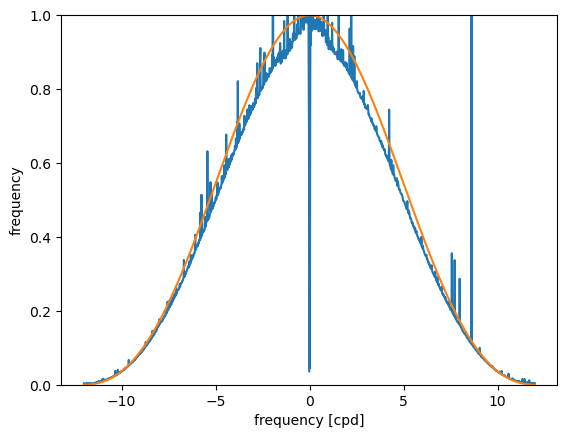

In [48]:
# une dérivation centrée :
a = (dsgc.E_vxy / dsgc.E_xyw2).mean(["lon_bins", "lat_bins"])
a.plot()
H2centered(dsgc.frequency, 1 / 24).plot()
plt.ylim(0, 1)

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.0, 5.0)

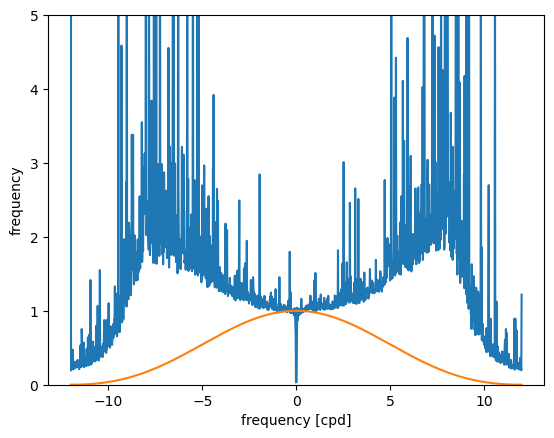

In [8]:
# une dérivation centrée :
a = (dsgc.E_ven / dsgc.E_xyw2).mean(["lon_bins", "lat_bins"])
a.plot()
H2centered(dsgc.frequency, 1 / 24).plot()
plt.ylim(0, 5)

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


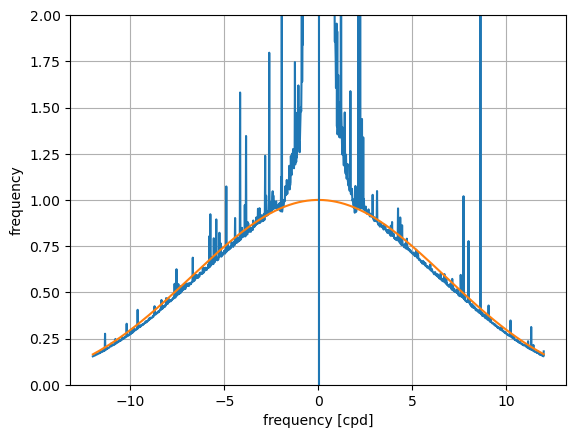

In [44]:
# 2 dérivations non centrées (calcul à partir de lonlat )
a = (dsgc.E_axy / dsgc.E_xyw4).mean(["lon_bins", "lat_bins"])
a.plot()
(H2(dsgc.frequency, 1 / 24) ** 2).plot()
plt.axvline(1 / 24)
plt.ylim(0, 2)
plt.grid()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


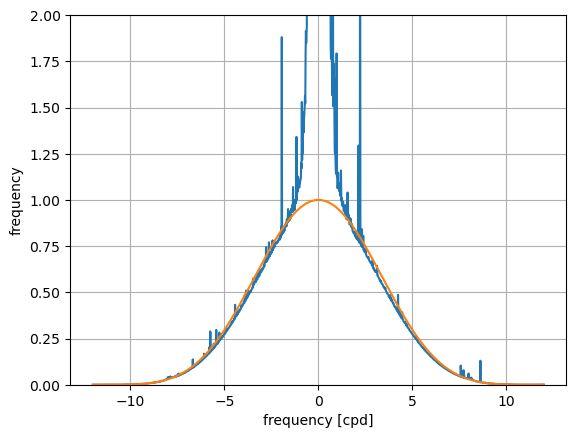

In [49]:
# 2 dérivations centrées (calcul à partir de vxvy)
a = (dsgc.E_avxy / dsgc.E_xyw4).mean(["lon_bins", "lat_bins"])
a.plot()
((H2centered(dsgc.frequency, 1 / 24)) ** 2).plot()
plt.ylim(0, 2)
plt.grid()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


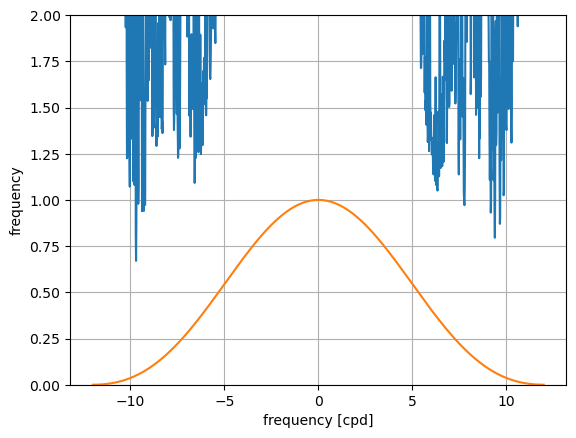

In [53]:
# 1 dérivations centrées (calcul à partir de vxvy)
a = (dsgc.E_avxy / dsgc.E_vxyw2).mean(["lon_bins", "lat_bins"])
a.plot()
H2centered(dsgc.frequency, 1 / 24).plot()
plt.ylim(0, 2)
plt.grid()

(1e-06, 100.0)

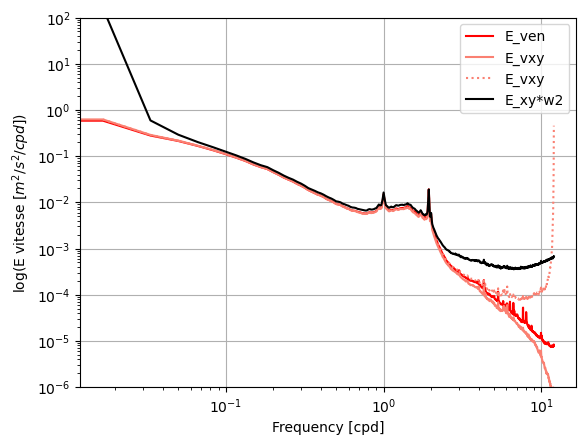

In [6]:
dsgc.E_ven.mean(["lon_bins", "lat_bins"]).plot(label="E_ven", color="red")
dsgc.E_vxy.mean(["lon_bins", "lat_bins"]).plot(label="E_vxy", color="salmon")
(dsgc.E_vxy / H2centered(dsgc.frequency, 1 / 24)).mean(["lon_bins", "lat_bins"]).plot(
    label="E_vxy", color="salmon", ls=":"
)

dsgc.E_xyw2.mean(["lon_bins", "lat_bins"]).plot(label="E_xy*w2", color="k")

plt.grid()
plt.xlabel("Frequency [cpd]")
plt.ylabel(r"log(E vitesse $[m^2/s^2/cpd]$)")
plt.xscale("log")
plt.yscale("log")
# (1 / dsa.frequency**2 * 1e-1).plot(ax=a, label="-2", ls="--")
# (1 / dsa.frequency * 1e-1).plot(ax=a, label="-1", ls="--")
plt.legend()
plt.ylim(1e-6, 1e2)
# ax[0].set_title("GPS")
# ax[1].set_title("Argos")

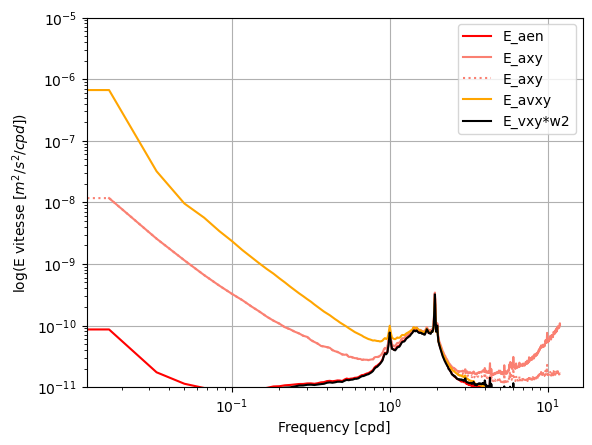

In [27]:
dsgc.E_aen.mean(["lon_bins", "lat_bins"]).plot(label="E_aen", color="red")
(dsgc.E_axy / H2(dsgc.frequency, 1 / 24)).mean(["lon_bins", "lat_bins"]).plot(
    label="E_axy", color="salmon"
)
dsgc.E_axy.mean(["lon_bins", "lat_bins"]).plot(label="E_axy", color="salmon", ls=":")
dsgc.E_avxy.mean(["lon_bins", "lat_bins"]).plot(label="E_avxy", color="orange")
# (dsgc.E_avxy/H2centered(dsgc.frequency, 1/24)).mean(["lon_bins", "lat_bins"]).plot(label="E_avxy", color="orange", ls=':')
dsgc.E_vxyw2.mean(["lon_bins", "lat_bins"]).plot(label="E_vxy*w2", color="k")


plt.grid()
plt.xlabel("Frequency [cpd]")
plt.ylabel(r"log(E vitesse $[m^2/s^2/cpd]$)")
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-11, 1e-5)
# (1 / dsa.frequency**2 * 1e-1).plot(ax=a, label="-2", ls="--")
# (1 / dsa.frequency * 1e-1).plot(ax=a, label="-1", ls="--")
plt.legend()

# ax[0].set_title("GPS")
# ax[1].set_title("Argos")

In [5]:
dsgc

<xarray.Dataset>
Dimensions:        (lon_bins: 180, lat_bins: 90, frequency: 1440)
Coordinates:
  * frequency      (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins       (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon_bins       (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
Data variables: (12/13)
    E_aen          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_avxy         (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_axy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_err_lonlat   (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_err_lonlatm  (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_err_vevn     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    ...             ...
    E_venw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxy          (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxydiff      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxyw2        (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_xy           (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    nb_geobins     (lon_bins, lat_bins) int64 dask.array<chunksize=(180, 90), meta=np.ndarray>

In [16]:
x = np.linspace(-3 * np.pi, 3 * np.pi, 100)
a2 = (2 / (x**2) * (1 - np.cos(x))) ** 2
a1 = (np.sin(x) ** 2 / (x**2)) ** 2

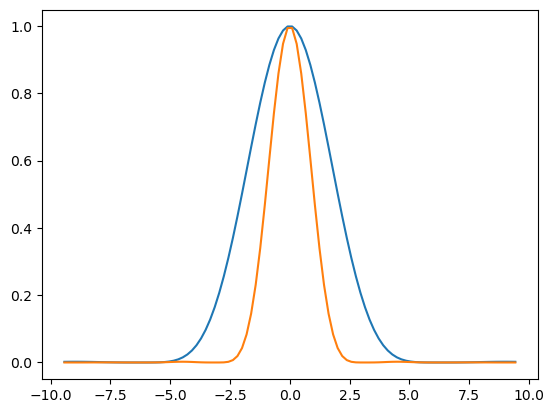

In [17]:
plt.plot(x, a2)
plt.plot(x, a1)